In [ ]:
import torch
import torch.nn as nn
import math
class _Residual_Block(nn.Module):
    def __init__(self):
        super(_Residual_Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in1 = nn.InstanceNorm2d(64, affine=True)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in2 = nn.InstanceNorm2d(64, affine=True)

    def forward(self, x):
        identity_data = x
        output = self.relu(self.in1(self.conv1(x)))
        output = self.in2(self.conv2(output))
        output = torch.add(output,identity_data)
        return output 

class _NetG(nn.Module):
    def __init__(self):
        super(_NetG, self).__init__()

        self.conv_input = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4, bias=False)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
        self.residual = self.make_layer(_Residual_Block, 16)

        self.conv_mid = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_mid = nn.InstanceNorm2d(64, affine=True)

        self.upscale4x = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_output = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        print(x.shape)
        out = self.relu(self.conv_input(x))
        residual = out
        out = self.residual(out)
        out = self.bn_mid(self.conv_mid(out))
        out = torch.add(out,residual)
        out = self.upscale4x(out)
        out = self.conv_output(out)
        return out
    
model = _NetG()
model = model.cuda()

x = torch.zeros([1,3,256,256]).cuda()
output = model(x)

print(output.shape)

In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

class _Residual_Block(nn.Module):
    def __init__(self):
        super(_Residual_Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in1 = nn.InstanceNorm2d(64, affine=True)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in2 = nn.InstanceNorm2d(64, affine=True)

    def forward(self, x):
        identity_data = x
        output = self.relu(self.in1(self.conv1(x)))
        output = self.in2(self.conv2(output))
        output = torch.add(output,identity_data)
        return output 

class myUpsample(nn.Module):
    def __init__(self, scale_factor, mode='bilinear', align_corners=False):
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners
    def forward(self, input):
        return F.interpolate(input, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class NetARW(nn.Module):
    def __init__(self, up_ratio=2, up_type='subpixel'):
        super(NetARW, self).__init__()
        
        self.up_ratio = up_ratio
        self.conv_input = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=9, stride=1, padding=4, bias=False)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
        self.residual = self.make_layer(_Residual_Block, 16)

        self.conv_mid = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_mid = nn.InstanceNorm2d(64, affine=True)
        if up_type == 'subpixel':
            self.upscale2x = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.upscale2x_1 = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.upscale2x_2 = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True),
            )
        if up_type == 'deconv':
            self.upscale2x = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                #F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.upscale2x_1 = nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.upscale2x_2 = nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                nn.LeakyReLU(0.2, inplace=True),
            )
        
        self.conv_output = nn.Conv2d(in_channels=256, out_channels=3, kernel_size=9, stride=1, padding=4, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        print(x.shape)
        out = self.relu(self.conv_input(x))
        residual = out
        out = self.residual(out)
        out = self.bn_mid(self.conv_mid(out))
        out = torch.add(out,residual)
        out = self.upscale2x(out)
        if self.up_ratio == 4:
            out = self.upscale2x_1(out)
        
        if self.up_ratio == 8:
            out = self.upscale2x_1(out)
            out = self.upscale2x_2(out)
        
        print(out.shape)
        out = self.conv_output(out)
        return out

model = NetARW(up_type="deconv", up_ratio=2)
model = model.cuda()
x = torch.zeros([1,4,64,64]).cuda()
output = model(x)

print(output.shape)

In [ ]:
import torch
import numpy as np
a = torch.randn(1, 3, 256, 256)
#a = torch.from_numpy(np.arange(0,256)).view(1,1,16,16)
#print(a)
print(a.shape)
kernel_size = 8
kernel_stride = 8
a = a.unfold(2, kernel_size, kernel_stride)
print(a.shape)

a = a.unfold(3, kernel_size, kernel_stride)
print(a.shape)
a = a.contiguous().view(a.size(0), a.size(1), -1, a.size(4), a.size(5))
print(a.shape)
# #print(a)

# a.permute((0,2,3,4,1)).shape
a = a.view(a.shape[:5])
print(a.shape)



In [ ]:
import torch.nn as nn
import torch
class PatchNonlocalPool(nn.Module):

    def __init__(self, n_feats, patch_size):
        super(PatchNonlocalPool,self).__init__()
        self.patch_size = patch_size
        #self.conv = nn.Conv2d(1024, 1024,kernel_size=patch_size,stride=1,padding=0,bias=False)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        #self.avg_pool2 = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        b,n,h,w = x.shape
        kernel_size = self.patch_size
        kernel_stride = self.patch_size
        # [b, 64, 32, 32, 8, 8]
        # x [b, 64, 256, 256] => [b, 64, 8, 8, 1024]
        x = x.view(x.shape[0]*x.shape[1], x.shape[2],x.shape[3])
        a = x.unfold(1, kernel_size, kernel_stride).unfold(2,kernel_size,kernel_stride)
        a = a.contiguous().view(a.size(0), -1, a.size(3), a.size(4))
        # => [b*64, 1024, 8, 8]
        #[b*64,1024,64] a_i
        a1 = a.view(*a.shape[:2],-1)
        #[b*64,64,1024] a_j
        a2 = a1.permute((0,2,1))
        #[b*64,1024,1024] => f(x_i, x_j)
        f1 = torch.bmm(a1, a2)
        #print(f1.shape)
        #[b*64,1024,1,1]
        #print(a.shape)
        #[b*64,1024,1,1]
        y1 = self.avg_pool(a)
        #[b*64,1024,1]
        y1 = y1.view(y1.shape[:3])
        
        #[b*64,1024,1024]
        y2 = torch.mul(f1,y1)
        
        y3 = self.avg_pool(y2)
        return y3.view(b,n,1,1)

PNLpool = PatchNonlocalPool(64,16)
PNLpool = PNLpool
#.cuda()
x = torch.randn(16,64,256,256)
#.cuda()
x = PNLpool(x)
print(x.shape)

In [ ]:
a = torch.randn(3,4,10)
b = torch.randn(3,10,4)

torch.matmul(a,b).shape

In [ ]:

h = w = 256
n = 20

print(h % n != 0)
if h % n != 0:
    print("hello world")
if h % n != 0 or w % n != 0 :
    raise ValueError("n: %d can not be division by h: %d or w: %d" %(n, h, w))

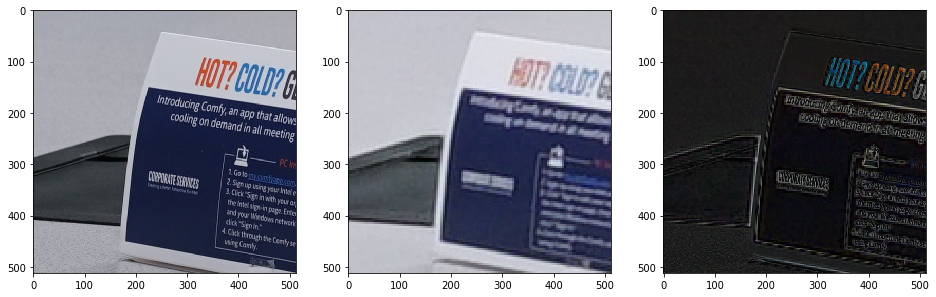

786432
[53001, 366651, 87620, 77379, 45710, 25185, 17358, 12320, 9166, 6430]


/home/lrh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/home/lrh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/lrh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater
/home/lrh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less


<BarContainer object of 10 artists>

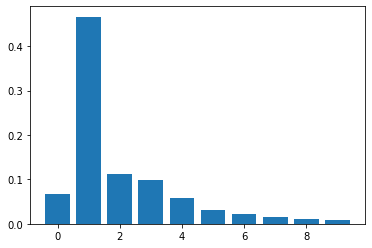

In [13]:
import os
data_root = '/store2/dataset/SR/train_data/SRRAW/X4/train/'
file_name = '00006_00007.png'

hr_path = os.path.join(data_root, 'HR', file_name)
lr_path = os.path.join(data_root, 'LR', file_name)

from PIL import Image

hr_img = Image.open(hr_path)
lr_img = Image.open(lr_path)

lr_img = lr_img.resize(hr_img.size)


new_height = new_width = 512
width, height = hr_img.size   # Get dimensions
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2
hr_img = hr_img.crop((left, top, right, bottom))
lr_img = lr_img.crop((left, top, right, bottom))
import numpy as np
from PIL import ImageChops

# lr_img_np = np.array(lr_img)
# hr_img_np = np.array(hr_img)

# res_img = hr_img_np - lr_img_np

res_img = ImageChops.difference(hr_img, lr_img)

from matplotlib import pyplot as plt
plt.figure(figsize=(16,16))



plt.subplot(131)
plt.imshow(hr_img)

plt.subplot(132)
plt.imshow(lr_img)

plt.subplot(133)
plt.imshow(res_img)

#print(np.array(res_img))

plt.show()
a = np.array(res_img) / np.array(hr_img)

print(a.size)


num = []
for i in range(10):
    num.append(((a>i/10) & (a<(i+1)/10)).sum())

print(num)
num = np.array(num)
num = num / a.size
plt.bar(range(10), num)

# r,g,b=res_img.split()

# plt.figure("ResImage")
# ar = np.array(r).flatten()
# plt.hist(ar, bins=256, density=1,facecolor='r',edgecolor='r',histtype='step')
# ag=np.array(g).flatten()
# plt.hist(ag, bins=256, density=1, facecolor='g',edgecolor='g',histtype='step')
# ab=np.array(b).flatten()
# plt.hist(ab, bins=256, density=1, facecolor='b',edgecolor='b',histtype='step')
# plt.show()



# print((a<0.1).sum())
# #print((0.1<a<0.2).sum())
# print(((a>0.2) & (a<0.3)).sum())
# print(((a>0.6) & (a<0.7)).sum())
# print(((a>0.7) & (a<0.8)).sum())
# print(((a>0.8) & (a<0.9)).sum())
# print(((a>0.9) & (a<1.0)).sum())
#print(((a>1)).sum())

[[0.11372549 0.11372549 0.11372549 ... 0.10196078 0.10196078 0.09803922]
 [0.10588235 0.10980392 0.11764706 ... 0.10196078 0.10196078 0.09803922]
 [0.10588235 0.10980392 0.11764706 ... 0.10196078 0.10588235 0.10196078]
 ...
 [0.09411765 0.07058824 0.03529412 ... 0.16862745 0.16078431 0.14901961]
 [0.18431373 0.19607843 0.1372549  ... 0.15294118 0.16470588 0.18039216]
 [0.15294118 0.21568627 0.21176471 ... 0.16078431 0.09803922 0.03137255]]


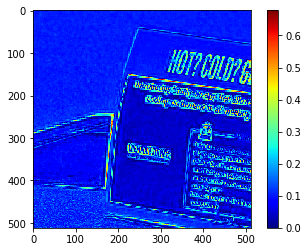

In [11]:
import seaborn as sns
import numpy as np
res_img1 = res_img.convert("L")
res_img1 = np.array(res_img1) / 255.0
print(res_img1)
plt.imshow(res_img1, cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
import torch

a = torch.randn(4,3)

print(a)
print(a.shape)

import torch.nn.functional as F
b = F.softmax(a, dim=-1)

print(b)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class PatchNonlocalPool(nn.Module):
    def __init__(self, n_feats, patch_size=16):
        super(PatchNonlocalPool,self).__init__()
        self.patch_size = patch_size
        self.conv = nn.Conv2d(n_feats, n_feats,kernel_size=3,stride=1,padding=1,bias=False)
        self.avg_pool1 = nn.AdaptiveAvgPool2d(1)
        self.avg_pool2 = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        b,n,h,w = x.shape
        kernel_size = self.patch_size
        kernel_stride = self.patch_size
        # [b*64, 16, 16, 16, 16]
        # x [b*64, 256, 256] => [b*64, 256, 16, 16]
        x = x.view(b*n, h,w)
        a = x.unfold(1, kernel_size, kernel_stride).unfold(2,kernel_size,kernel_stride)
        a = a.contiguous().view(a.size(0), -1, a.size(3), a.size(4))
        # => [b*64, 256, 16, 16]
        #[b*64,256,256_fm] a_i
        a1 = a.view(*a.shape[:2],-1)
        #[b*64,256_fm,256] a_j
        a2 = a1.permute((0,2,1))
        #[b*64,256,256] => f(x_i, x_j)
        f1 = torch.matmul(a1, a2)
        f_div_C = F.softmax(f1, dim=-1)
        #[b*64,256,1,1]
        y1 = self.avg_pool1(a)
        #[b*64,256,1]
        y1 = y1.view(y1.shape[:3])
        #[b*64,256,256]
        #y2 = torch.mul(f1,y1)
        #[b*64,256,1]
        y2 = torch.matmul(f_div_C, y1)
        #y3 = self.avg_pool2(y2)
        #[b, 64, 16, 16]
        y2 = y2.contiguous().view(b,n, int(h/self.patch_size), int(w/self.patch_size))
        y2 = self.conv(y2)
        #[b,64,1,1]
        y2 = self.avg_pool1(y2)
        return y2

a = torch.randn(16,64,256,256)
pp = PatchNonlocalPool(n_feats=64)
